In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
test_results = pd.read_csv('data110/test_results.csv')
test_results

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0
...,...,...,...,...,...,...,...,...
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0


In [6]:
users = pd.read_csv('data110/user_table.csv')
users

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68
...,...,...,...,...,...
275611,485975,Atlanta,USA,33.76,-84.42
275612,35479,Los Angeles,USA,34.11,-118.41
275613,516519,Chicago,USA,41.84,-87.68
275614,984877,Tampa,USA,27.96,-82.48


In [8]:
test_merged = pd.merge(test_results, users, how='left', on='user_id')
test_merged

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02
...,...,...,...,...,...,...,...,...,...,...,...,...
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0,Bell Gardens,USA,33.97,-118.15
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0,West Seneca,USA,42.84,-78.75
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0,Walnut Creek,USA,37.90,-122.04


In [10]:
def ab_test():
    group_means = test_merged.groupby('city')['converted'].mean()
    observed_diff = group_means.iloc[1] - group_means.iloc[0]
    combined_values = test_merged['converted'].values
    permutation_diffs = []
    for _ in range(1000):
        np.random.shuffle(combined_values)  
        test_merged['city'] = np.random.permutation(test_merged['city']) 
        perm_means = test_merged.groupby('city')['converted'].mean()
        perm_diff = perm_means.iloc[1] - perm_means.iloc[0]
        permutation_diffs.append(perm_diff)
    p_value = sum(abs(diff) >= abs(observed_diff) for diff in permutation_diffs) / 1000
    plt.hist(permutation_diffs, bins=40, edgecolor='black')
    plt.axvline(observed_diff, color='red', label='Observed Difference')
    plt.title('Permutation Test Differences')
    plt.xlabel('Difference in Means')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    return p_value, observed_diff

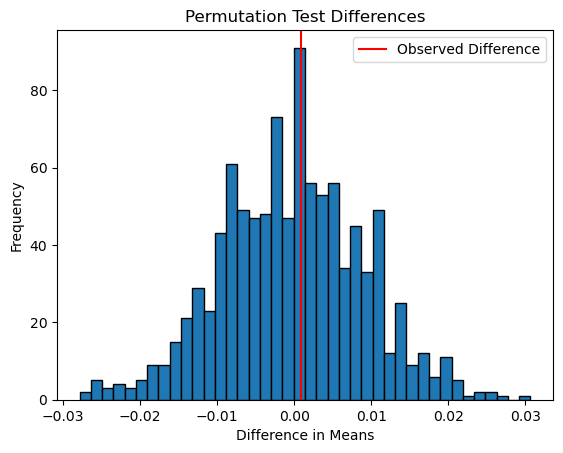

(0.924, 0.0009371223235463307)

In [12]:
test_merged = test_merged.drop(columns=['country', 'device', 'operative_system', 'source', 'user_id', 'timestamp', 'lat', 'long'])
ab_test()